In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import re
import requests 
import scrapy
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from datetime import datetime
import time
import random
from glob import glob

def text_to_response(text,url = 'http://dummy.com'): 
    text = "\'\'\'" + text + "\'\'\'"
    response = scrapy.http.HtmlResponse(url=url, body=text, encoding='utf8')
    return response

def clean_tag(input_string, pad_space=False):
    if pad_space:
        output = re.sub('<.*?>', ' ', input_string)
    else:
        output = re.sub('<.*?>', '', input_string)
    return output.strip()

In [2]:
data_storage_folder = '/Users/Sarah/Desktop/ancestry/us_census_data/'

homepage_url = 'https://www.ancestrylibrary.com'

driver = webdriver.Firefox(executable_path='/Users/Sarah/geckodriver')
driver.implicitly_wait(10)
driver.get(homepage_url)
time.sleep(3+random.random()*1)

year_to_which_year_index = dict(zip('1940 1930 1920 1910 1900 1890 1880 1870 1860 1850 1840 1830 1820 1810 1800 1790'.split(), [str(i) for i in range(1,16+1)]))

In [3]:
year = input('Which year?  ')
state = input('Which state?  [default NY]')
county = input('Which county?  [default NY]')
township = input('Which township?  ')
which_year_index = year_to_which_year_index[year]
state = state if state != '' else 'New York'
county = county if county != '' else 'New York'
year_url = driver.find_element_by_xpath('//section[@id="usCensusRecords"]/ul/li['+str(which_year_index)+']/a').get_attribute("href")
year_id = year_url.split('?dbid=')[-1]

Which year?  1880
Which state?  [default NY]New York
Which county?  [default NY]New York
Which township?  New York City


In [5]:
driver.get(year_url)
time.sleep(3+random.random()*1)

driver.find_element_by_xpath("//select[@id='browseOptions0']/option[text()='"+state+"']").click()
time.sleep(3+random.random()*1)

driver.find_element_by_xpath("//select[@id='browseOptions1']/option[text()='"+county+"']").click()
time.sleep(3+random.random()*1)

driver.find_element_by_xpath("//select[@id='browseOptions2']/option[text()='"+township+"']").click()
time.sleep(5+random.random()*1)

response = text_to_response(driver.page_source)

district_url_list = response.xpath('//div[@id="browselevel3"]/ul/li/a/@href').extract()

district_name_list = response.xpath('//div[@id="browselevel3"]/ul/li/a/text()').extract()

assert(len(district_url_list)==len(district_name_list))

district_number_of_images = []

for i in range(0, len(district_url_list)):
    
    if i%5==0:
        print(i,end=', ')
    
    district_url = district_url_list[i]
    district_name = district_name_list[i]

    driver.get(district_url)

    time.sleep(3+random.random()*1)
    
    try:
        number_of_images = int(text_to_response(driver.page_source).xpath('//span[@class="imageCountText middle"]/text()').extract()[0])
    except:
        time.sleep(2)
        number_of_images = int(text_to_response(driver.page_source).xpath('//span[@class="imageCountText middle"]/text()').extract()[0])
        
    district_number_of_images.append(number_of_images)

assert(len(district_url_list)==len(district_name_list)==len(district_number_of_images))

driver.quit()

this_year_state_township = '_'.join([year,state,township])
print('This_year_state_township:',this_year_state_township)

separater = '-' if (('_' not in district_url_list[0]) and ('-' in district_url_list[0])) else '_'
this_year_state_township_df = pd.DataFrame([re.findall('iid=(.*?)'+separater+'(.*?)&',url)[0] for url in district_url_list],columns=['district_id','image_id'])
this_year_state_township_df['district_number_of_images'] = district_number_of_images
this_year_state_township_df['district_name'] = district_name_list

0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, This_year_state_township: 1880_New York_New York City


In [11]:
from selenium.webdriver.firefox.firefox_profile import FirefoxProfile
driver = webdriver.Firefox(executable_path='/Users/Sarah/geckodriver')
driver.implicitly_wait(10)
driver.get(homepage_url)

api_url = "https://www.ancestrylibrary.com/interactive/api/v1/image/gridline/"+year_id+"/"+this_year_state_township_df.district_id[0]+"-"+this_year_state_township_df.image_id[0]
print(api_url)
driver.get(api_url)
driver.find_element_by_xpath("//a[@id='rawdata-tab']").click()
data = eval(text_to_response(driver.page_source).xpath("//pre[@class='data']/text()").extract()[0].replace('null','""'))
first_few_fields = list(data['RecordRectangles'][0].keys())
first_few_fields = first_few_fields[:first_few_fields.index('Cells')]
fields = ['DataID'] + first_few_fields + [c['DisplayFields'][0]['DisplayLabel'] if len(c['DisplayFields'])>0 else '' for c in data['RecordRectangles'][0]['Cells']]

driver.quit()

https://www.ancestrylibrary.com/interactive/api/v1/image/gridline/6742/4242244-00209


In [12]:
def get_json_from_url(api_url):
    driver.get(api_url)
    driver.find_element_by_xpath("//a[@id='rawdata-tab']").click()
    data = eval(text_to_response(driver.page_source).xpath("//pre[@class='data']/text()").extract()[0].replace('null','""'))
    
    data_id = data['ImageId']
    data_content = data['RecordRectangles']
    data_content = [[data_id] + [row[f] for f in first_few_fields] + [c['DisplayFields'][0]['DisplayValue'] if len(c['DisplayFields'])>0 else '' for c in row['Cells']] for row in data_content]
    
    time.sleep(0.3+random.random()*0.2)
    
    return data_content

from selenium.webdriver.firefox.firefox_profile import FirefoxProfile
driver = webdriver.Firefox(executable_path='/Users/Sarah/geckodriver')
driver.implicitly_wait(10)
driver.get(homepage_url)

In [13]:
for i,row in this_year_state_township_df.iterrows():
    
    if i >= 486:
        
        print('-----------'+str(i)+'-----------')
        
        start = datetime.now()
        
        district_id,image_id,district_number_of_images,district_name = list(row)
        print('Start',district_id)
        print(district_number_of_images)

        image_id = int(image_id)
        image_counter = 0
        data_list = []
        data_check = 0

        while image_counter < district_number_of_images:
            api_url = "https://www.ancestrylibrary.com/interactive/api/v1/image/gridline/"+year_id+"/"+district_id+"-"+str(image_id).zfill(5)
            data = get_json_from_url(api_url)
            if data:
                data_list += data
                image_id += 1
                image_counter += 1
            else:
                print("Skipping this url because it's empty.\n"+api_url+"\n")
                image_id += 1
                data_check += 1
            if data_check >= 8:
                print(image_counter)
                image_counter += 1
                print(image_counter)

        filename = data_storage_folder+this_year_state_township+'_'+district_name+'.csv'

        pd.DataFrame(data_list,columns = fields).to_csv(filename,index=False)
        
        time.sleep(3+random.random()*3)
        
        end = datetime.now()
                
        print(district_id,'Finished in '+str(round((end-start).seconds/60,1))+' minutes.')

    else:
        
        pass

driver.quit()

-----------486-----------
Start 4242230
24
4242230 Finished in 0.9 minutes.
-----------487-----------
Start 4242230
34
4242230 Finished in 1.5 minutes.
-----------488-----------
Start 4242230
35
Skipping this url because it's empty.
https://www.ancestrylibrary.com/interactive/api/v1/image/gridline/6742/4242230-00483

Skipping this url because it's empty.
https://www.ancestrylibrary.com/interactive/api/v1/image/gridline/6742/4242230-00515

4242230 Finished in 1.7 minutes.
-----------489-----------
Start 4242230
43
4242230 Finished in 1.8 minutes.
-----------490-----------
Start 4242230
44
4242230 Finished in 1.9 minutes.
-----------491-----------
Start 4242230
19
4242230 Finished in 0.8 minutes.
-----------492-----------
Start 4242230
35
4242230 Finished in 1.5 minutes.
-----------493-----------
Start 4242230
39
Skipping this url because it's empty.
https://www.ancestrylibrary.com/interactive/api/v1/image/gridline/6742/4242230-00686

Skipping this url because it's empty.
https://www.anc

Skipping this url because it's empty.
https://www.ancestrylibrary.com/interactive/api/v1/image/gridline/6742/4242231-00823

24
25
Skipping this url because it's empty.
https://www.ancestrylibrary.com/interactive/api/v1/image/gridline/6742/4242231-00824

25
26
Skipping this url because it's empty.
https://www.ancestrylibrary.com/interactive/api/v1/image/gridline/6742/4242231-00825

26
27
Skipping this url because it's empty.
https://www.ancestrylibrary.com/interactive/api/v1/image/gridline/6742/4242231-00826

27
28
Skipping this url because it's empty.
https://www.ancestrylibrary.com/interactive/api/v1/image/gridline/6742/4242231-00827

28
29
Skipping this url because it's empty.
https://www.ancestrylibrary.com/interactive/api/v1/image/gridline/6742/4242231-00828

29
30
Skipping this url because it's empty.
https://www.ancestrylibrary.com/interactive/api/v1/image/gridline/6742/4242231-00829

30
31
Skipping this url because it's empty.
https://www.ancestrylibrary.com/interactive/api/v1/i

Skipping this url because it's empty.
https://www.ancestrylibrary.com/interactive/api/v1/image/gridline/6742/4242234-00255

4242234 Finished in 2.0 minutes.
-----------563-----------
Start 4242234
36
4242234 Finished in 1.7 minutes.
-----------564-----------
Start 4242234
38
4242234 Finished in 1.5 minutes.
-----------565-----------
Start 4242234
42
Skipping this url because it's empty.
https://www.ancestrylibrary.com/interactive/api/v1/image/gridline/6742/4242234-00371

4242234 Finished in 1.8 minutes.
-----------566-----------
Start 4242234
37
4242234 Finished in 1.8 minutes.
-----------567-----------
Start 4242234
34
4242234 Finished in 1.6 minutes.
-----------568-----------
Start 4242234
45
4242234 Finished in 2.0 minutes.
-----------569-----------
Start 4242234
36
4242234 Finished in 1.7 minutes.
-----------570-----------
Start 4242234
46
4242234 Finished in 1.8 minutes.
-----------571-----------
Start 4242234
65
Skipping this url because it's empty.
https://www.ancestrylibrary.co

Skipping this url because it's empty.
https://www.ancestrylibrary.com/interactive/api/v1/image/gridline/6742/4242236-00113

4242236 Finished in 3.2 minutes.
-----------590-----------
Start 4242236
35
4242236 Finished in 1.6 minutes.
-----------591-----------
Start 4242236
46
Skipping this url because it's empty.
https://www.ancestrylibrary.com/interactive/api/v1/image/gridline/6742/4242236-00233

4242236 Finished in 1.9 minutes.
-----------592-----------
Start 4242236
34
4242236 Finished in 1.4 minutes.
-----------593-----------
Start 4242236
33
Skipping this url because it's empty.
https://www.ancestrylibrary.com/interactive/api/v1/image/gridline/6742/4242236-00283

4242236 Finished in 1.6 minutes.
-----------594-----------
Start 4242236
34
4242236 Finished in 1.6 minutes.
-----------595-----------
Start 4242236
32
4242236 Finished in 1.4 minutes.
-----------596-----------
Start 4242236
52
4242236 Finished in 2.2 minutes.
-----------597-----------
Start 4242236
37
4242236 Finished in 

Skipping this url because it's empty.
https://www.ancestrylibrary.com/interactive/api/v1/image/gridline/6742/4242238-00671

4242238 Finished in 2.5 minutes.
-----------639-----------
Start 4242238
24
Skipping this url because it's empty.
https://www.ancestrylibrary.com/interactive/api/v1/image/gridline/6742/4242238-00693

Skipping this url because it's empty.
https://www.ancestrylibrary.com/interactive/api/v1/image/gridline/6742/4242238-00694

Skipping this url because it's empty.
https://www.ancestrylibrary.com/interactive/api/v1/image/gridline/6742/4242238-00695

4242238 Finished in 1.0 minutes.
-----------640-----------
Start 4242238
43
4242238 Finished in 1.7 minutes.
-----------641-----------
Start 4242238
34
Skipping this url because it's empty.
https://www.ancestrylibrary.com/interactive/api/v1/image/gridline/6742/4242238-00771

4242238 Finished in 1.4 minutes.
-----------642-----------
Start 4242239
30
4242239 Finished in 1.3 minutes.
-----------643-----------
Start 4242239
42


4242240 Finished in 1.8 minutes.
-----------673-----------
Start 4242240
21
4242240 Finished in 0.8 minutes.
-----------674-----------
Start 4242240
32
4242240 Finished in 1.3 minutes.
-----------675-----------
Start 4242240
45
4242240 Finished in 1.8 minutes.
-----------676-----------
Start 4242240
30
4242240 Finished in 1.2 minutes.


In [18]:
files = sorted(glob(data_storage_folder+year+'_*'))

files = [pd.read_csv(f) for f in files]

df = pd.concat(files)

df.dropna(subset=['Name'],inplace=True)

df.reset_index(drop=True,inplace=True)

ffill_cols = ['House Number', 'Dwelling Number', 'Street']

df.loc[:,ffill_cols] = df.loc[:,ffill_cols].ffill()

df['Ward of City'] = township

df.drop(df.columns[df.notnull().sum()==0].tolist(), axis=1, inplace=True)

agg_filepath = data_storage_folder+'aggregate/'+this_year_state_township+'.csv'

df.to_csv(agg_filepath,index=False)

In [19]:
df = pd.read_csv(agg_filepath)

numeric_cols = [c for c in df.columns.tolist() if 'number' in c.lower()] + ['Age']

for col in numeric_cols:
    df[col] = df[col].apply(lambda x: int(x) if isinstance(x,float) and not np.isnan(x) else x )
    df[col] = df[col].apply(lambda x: x.replace('.0','') if isinstance(x,str) else x )
    df[col] = df[col].apply(lambda x: int(x) if isinstance(x,str) and x.isnumeric() else x )
    
df.to_csv(agg_filepath,index=False)

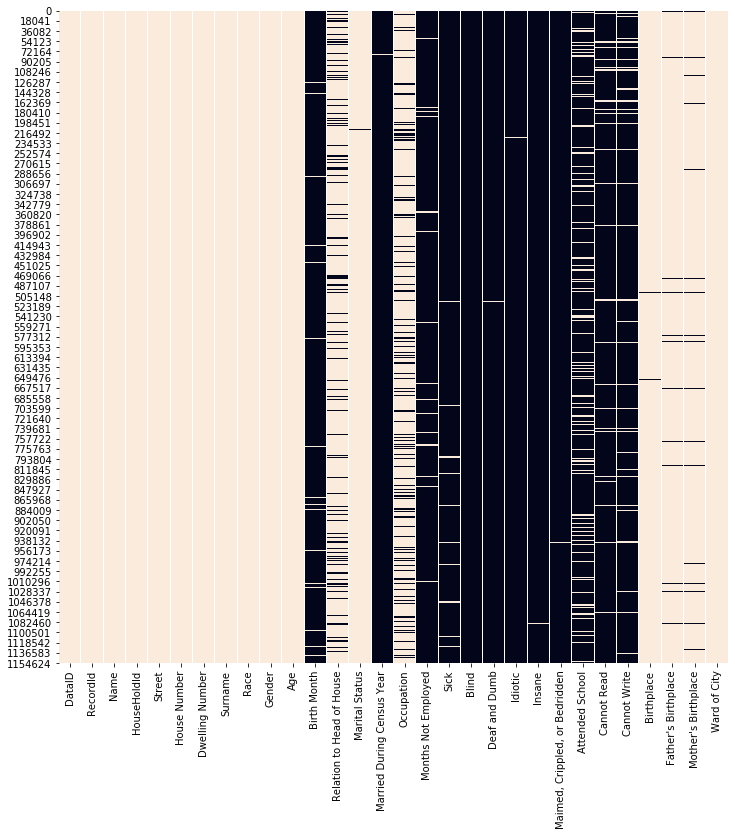

In [20]:
plt.figure(figsize=(12,12))
sns.heatmap(df.notnull(),cbar=False)

In [21]:
availability = np.round(df.notnull().sum()/len(df)*100,2)
print(availability)

DataID                            100.00
RecordId                          100.00
Name                              100.00
HouseHoldId                       100.00
Street                            100.00
House Number                      100.00
Dwelling Number                   100.00
Surname                           100.00
Race                               99.96
Gender                            100.00
Age                                99.97
Birth Month                         2.33
Relation to Head of House          84.26
Marital Status                     99.54
Married During Census Year          0.21
Occupation                         83.66
Months Not Employed                 3.18
Sick                                2.02
Blind                               0.15
Deaf and Dumb                       0.15
Idiotic                             0.09
Insane                              0.35
Maimed, Crippled, or Bedridden      0.52
Attended School                    14.96
Cannot Read     

In [22]:
print(f"There are {df.HouseHoldId.nunique()} families, {df.RecordId.nunique()} persons in {township} in {year}.")

There are 420718 families, 1166994 persons in New York City in 1880.
